# They don't see like we do!

A set of samples showing how pre-trained networks can't detect set of images. In this example I am using DeepLab and lots of images from the interent.

# References 

1. [DeepLab Readme in Tensorflow's Github Reposirty](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md)
1. [Notebook taken from Tensorflow's Github Reposirty](https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)
1. [Plot multiple images with matplotlib in a single figure](https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1)
1. [Scikit-Image - Rank filters](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html#sphx-glr-auto-examples-xx-applications-plot-rank-filters-py)

## Image Sources
1. [Star Wars Battlefront 2: Dumb Yet HILARIOUS Glitches - YouTube](https://www.youtube.com/watch?v=FKdAAQCoXNM)
1. [Aminoapps - Matthew Mercer provided the voice from Luke Skywalker](https://aminoapps.com/c/fire-emblem-amino/page/blog/did-you-know/V0Yg_e02F7u5pag0L3wXxm4v76r2j2DVbMP)

In [1]:
#@title Imports

import os
from io import BytesIO
import tarfile 
import tempfile
from six.moves import urllib

from tqdm import tqdm

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

from skimage.filters.rank import median
from skimage.morphology import disk
from skimage import img_as_ubyte

import tensorflow as tf

In [2]:
#@title Helper methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
  

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [3]:
#@title Some more helper functions

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
    
def image_grabber(url):
  f = urllib.request.urlopen(url)
  jpeg_str = f.read()
  original_im = Image.open(BytesIO(jpeg_str))
  return original_im    

In [4]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [5]:
image_path = ['faces/' + str(x+1) + '.jpg' for x in range(11)]
images = [Image.open(ip) for ip in image_path]

/home/taesiri/.conda/envs/deep36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


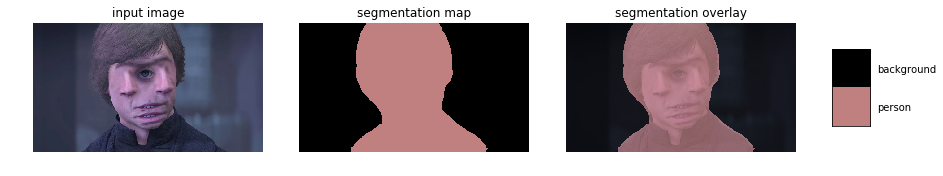

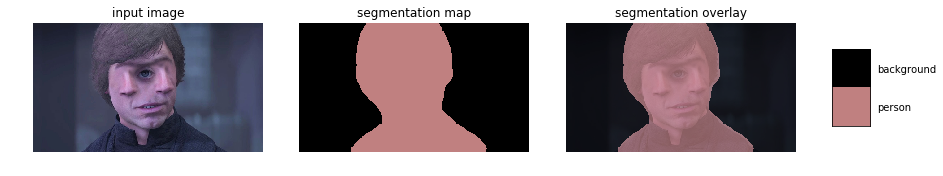

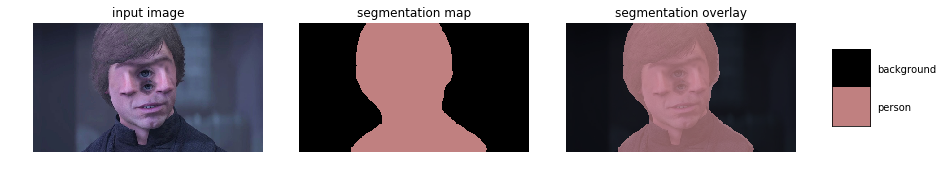

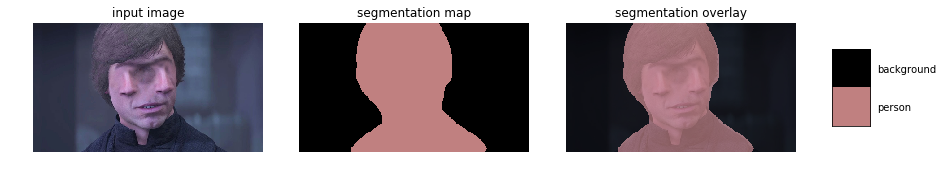

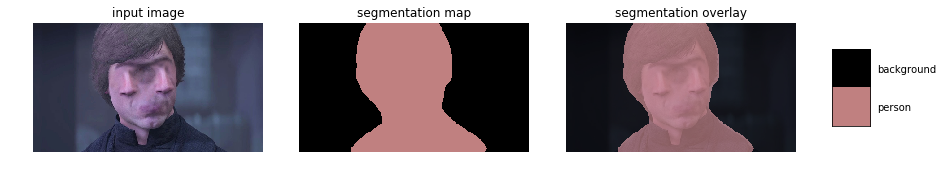

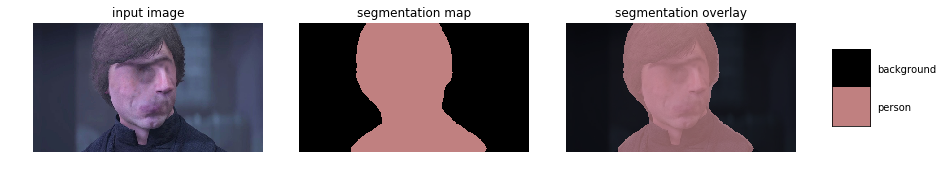

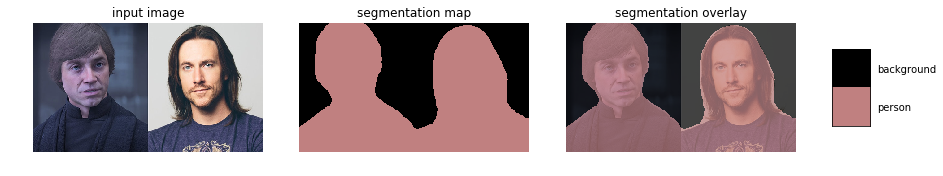

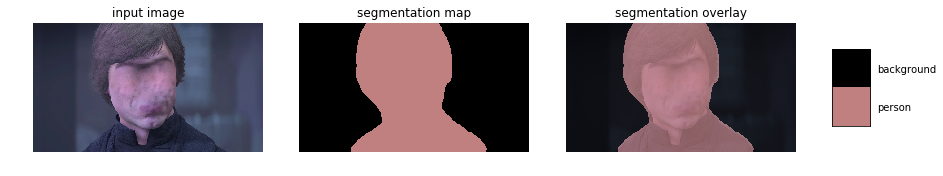

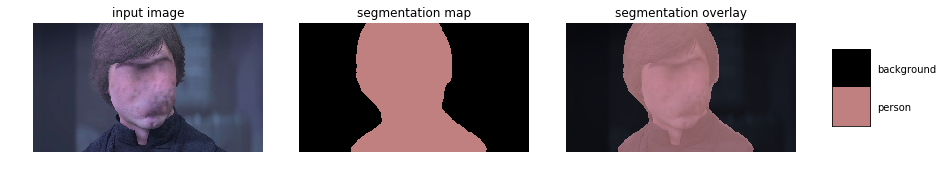

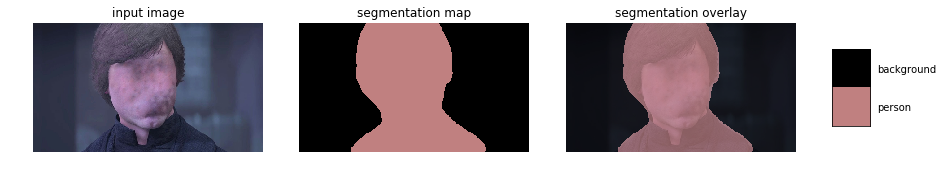

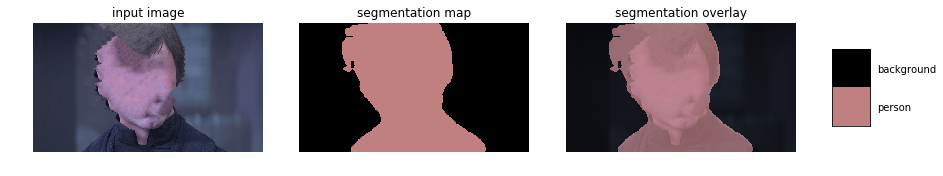

In [6]:
# Get segmentation map for each image
packed = [MODEL.run(img) for img in images]
resized_images = [item[0] for item in packed]
seg_maps =  [item[1] for item in packed]

# visualize segment maps
for i in range(len(packed)):
  vis_segmentation(resized_images[i], seg_maps[i])

In [ ]:
# m20 = median(noisy_image[:, :, 0], disk(20))
# im = Image.fromarray(np.uint8(m20))
# resized, seg_map = MODEL.run(im)
# vis_and_save_segmentation(resized, seg_map, 'temp.jpg', 'demo')

## Let's Make a movie!
``save_visualization`` is a helper function to save visualization for creating movie with ``ffmpeg``. 

### ``ffmpeg`` Commands

1. For creating a movie: ``ffmpeg -r 15 -i %d.jpg -c:v libx264 -vf "fps=25,format=yuv420p" out.mp4``
1. For reverseing an existing movie: ``ffmpeg -i out.mp4 -vf reverse reversed.mp4``

In [9]:
def save_visualization(image, seg_map, out_path, image_title = "input image"):
  """Visualizes (and Save) input image, segmentation map and overlay view."""
  fig = plt.figure(figsize=(20, 10))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[8, 8, 8, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title(image_title)

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('Segmentation Map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('Segmentation Overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  fig.savefig(out_path)
  plt.close(fig)

In [10]:
input_image = images[6].crop((0,0,730/2,410)).convert('LA')
image_data = img_as_ubyte(input_image)

In [ ]:
# Run this to generate all images
for ctr in tqdm(reversed(range(180))):
  filter_applied = median(image_data[:, :, 0], disk(ctr))
  im = Image.fromarray(np.uint8(filter_applied))
  resized, seg_map = MODEL.run(im)
  save_visualization(resized, seg_map, "output/{}.jpg".format(ctr), "Image #{}".format(180-ctr))

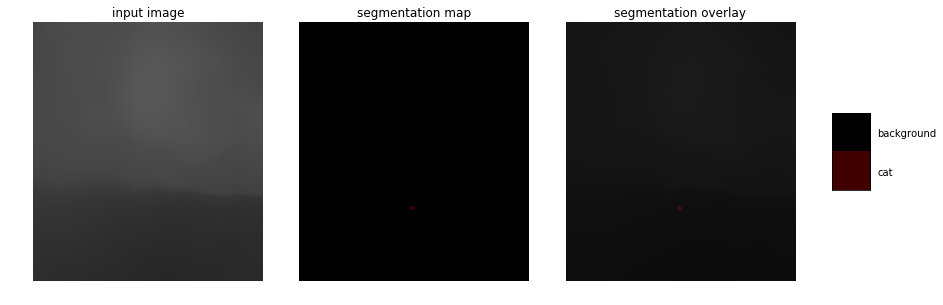

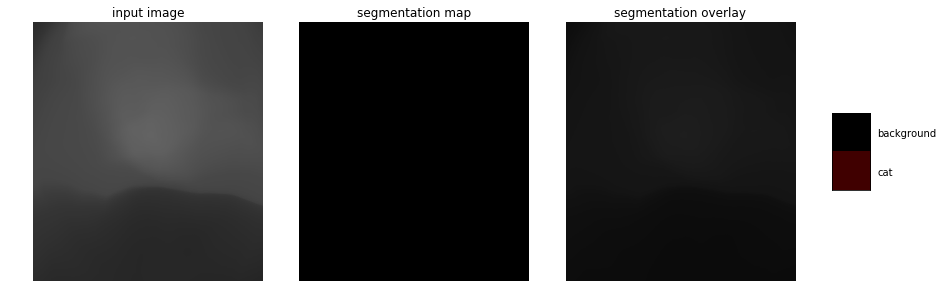

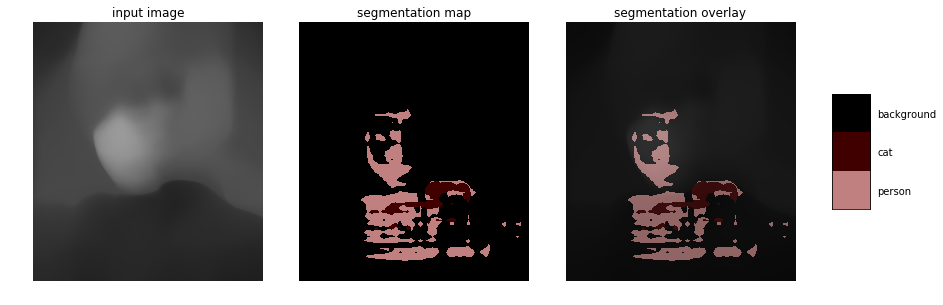

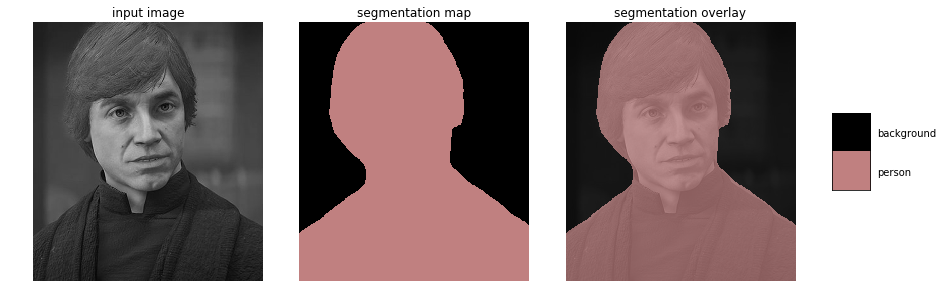

In [11]:
# Just for visualization purposes only!
for ctr in reversed(range(0, 180, 50)):
  filter_applied = median(image_data[:, :, 0], disk(ctr))
  im = Image.fromarray(np.uint8(filter_applied))
  resized, seg_map = MODEL.run(im)
  vis_segmentation(resized, seg_map)